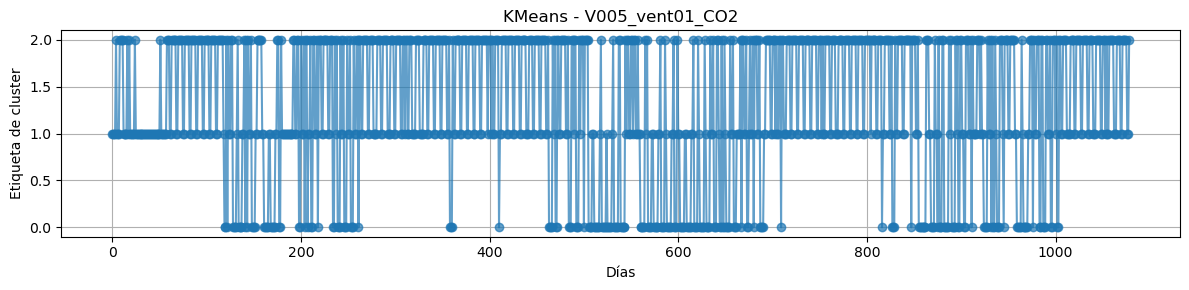

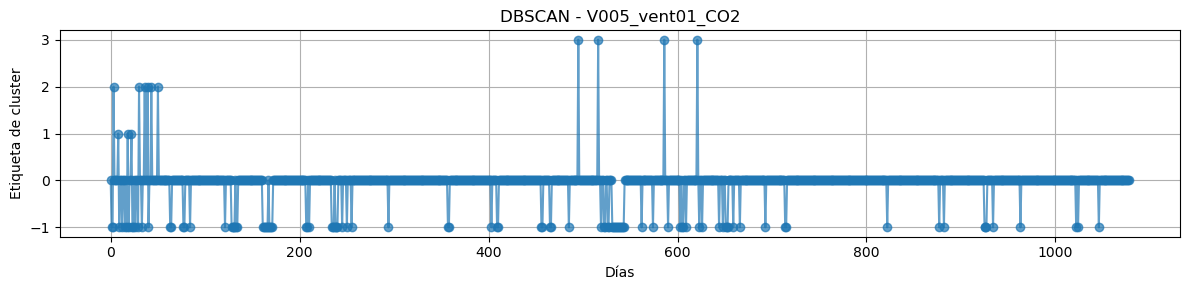

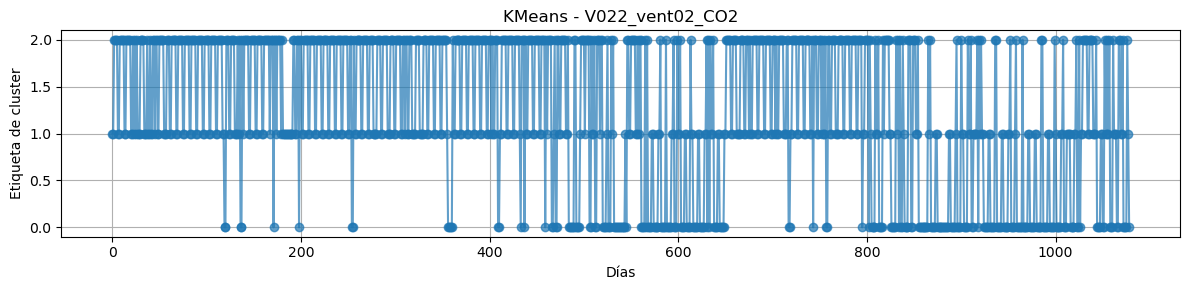

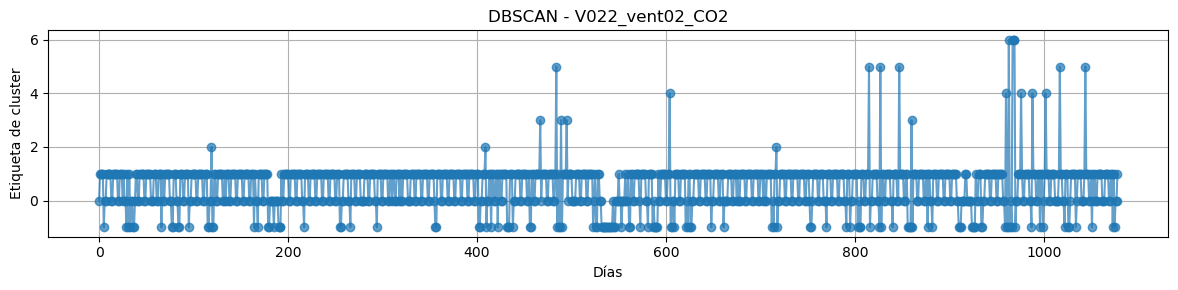

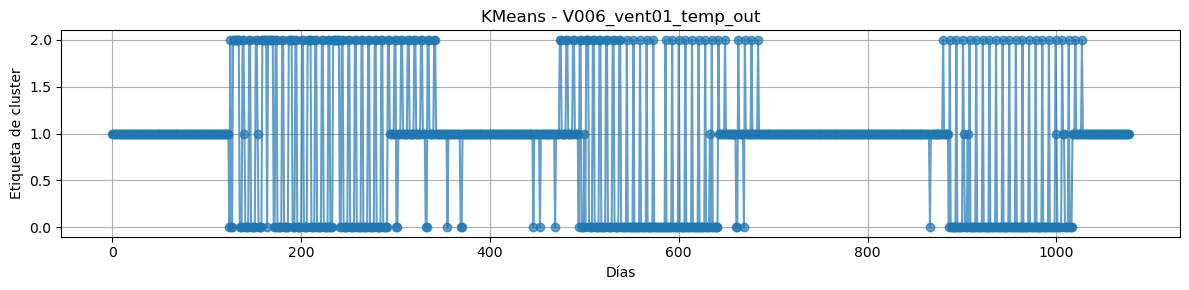

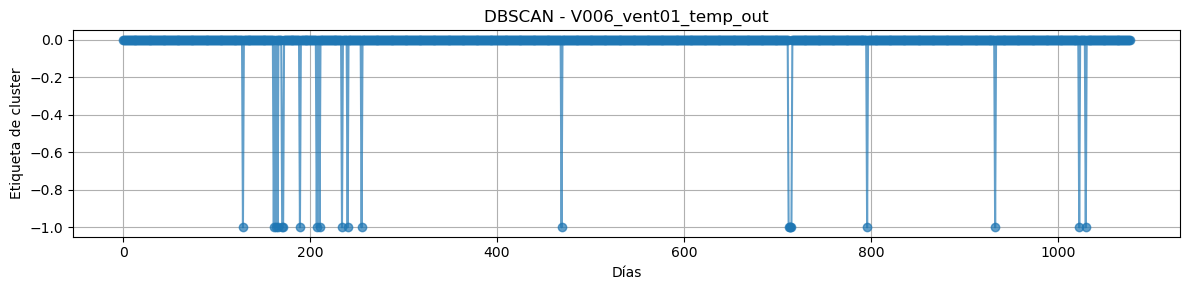

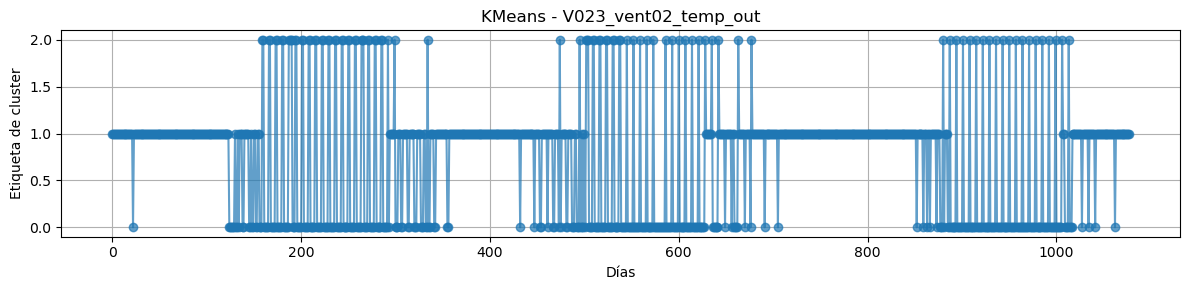

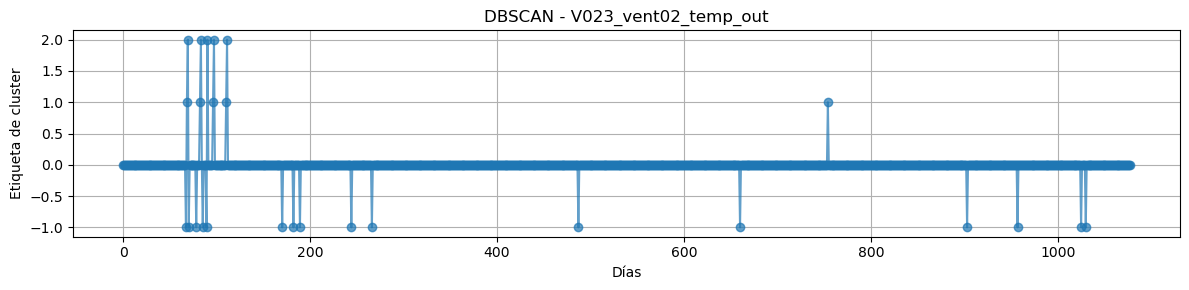

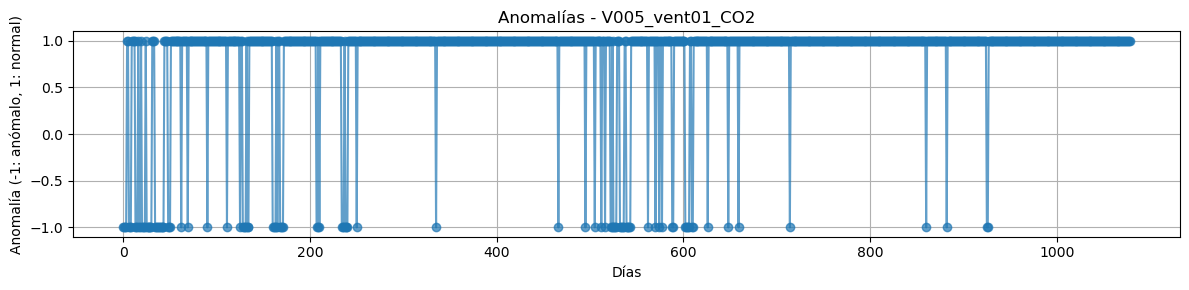

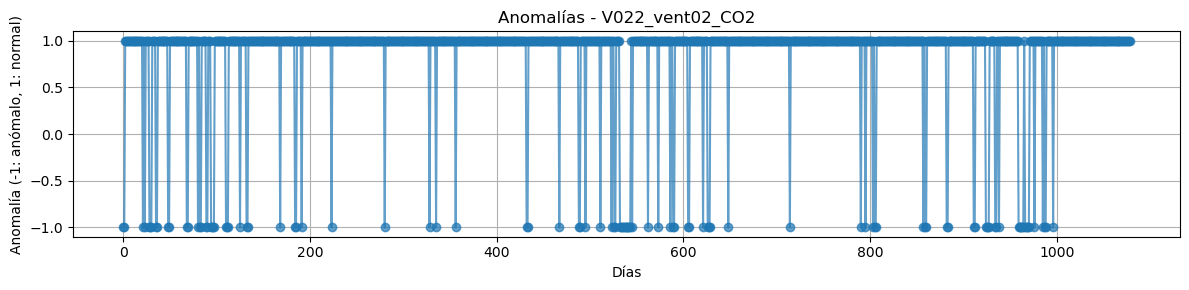

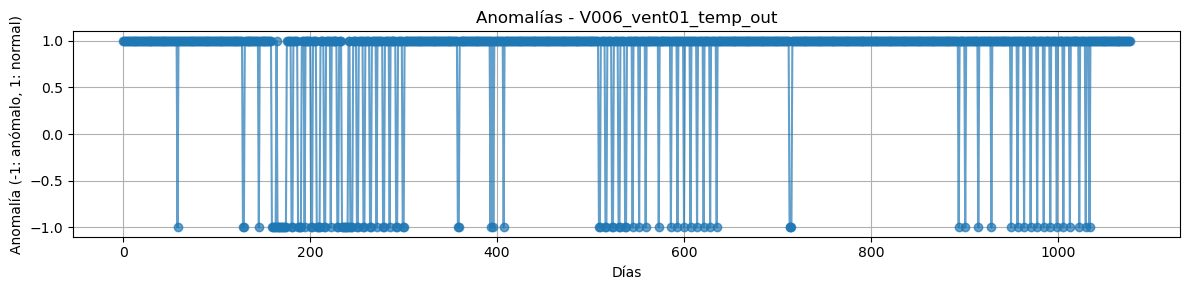

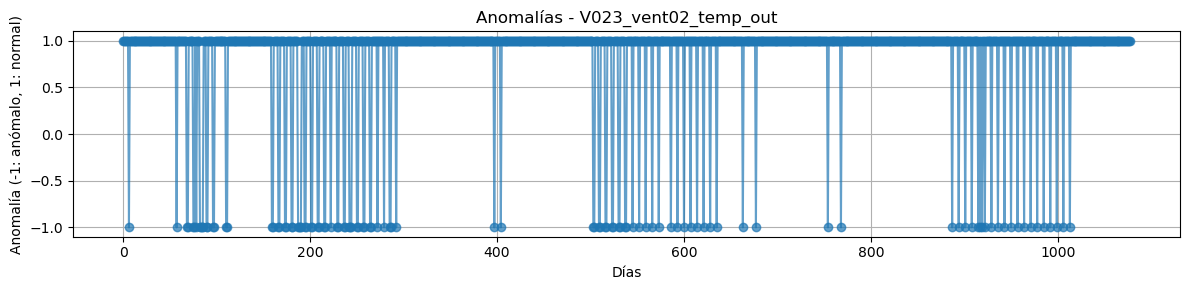

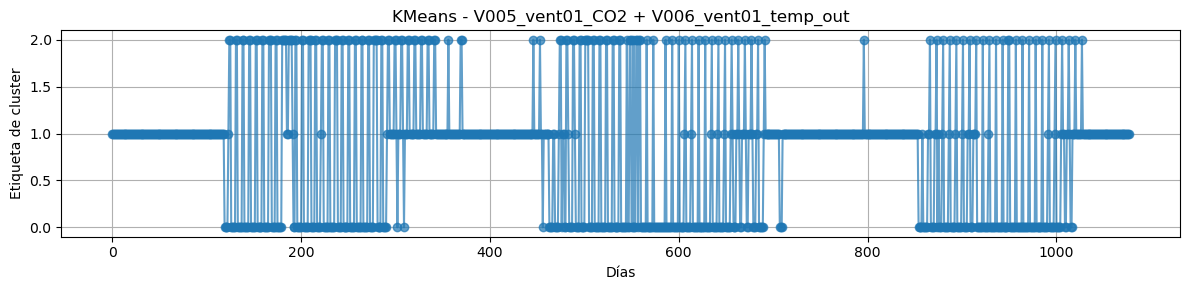

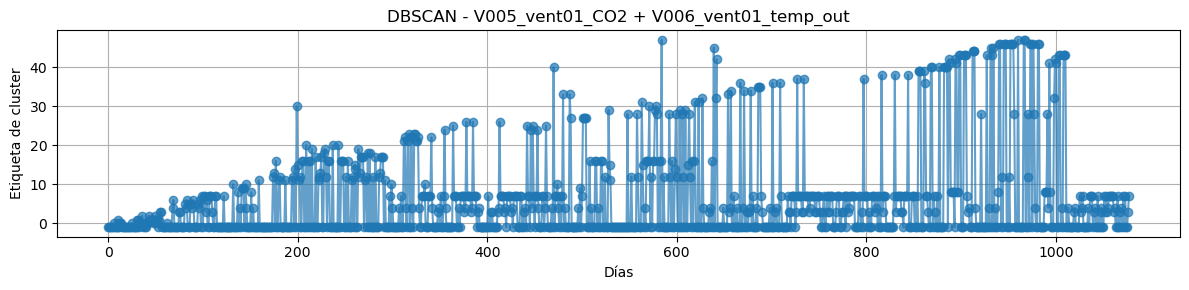

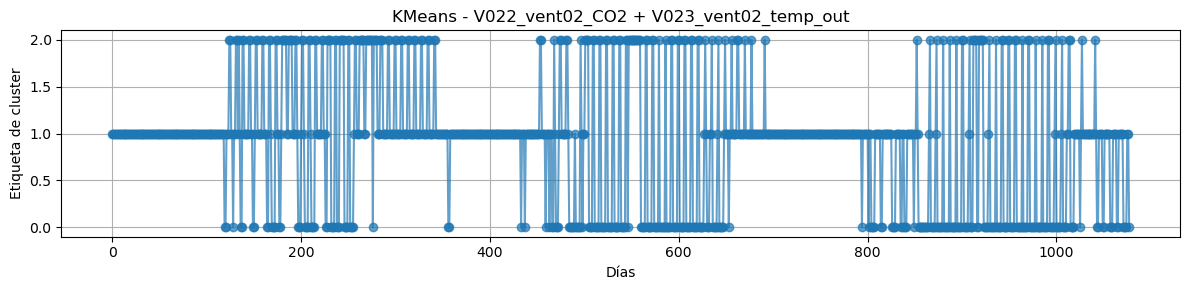

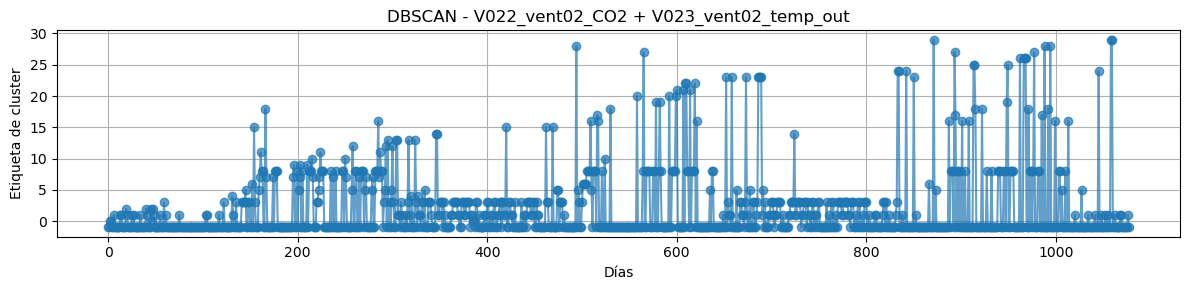

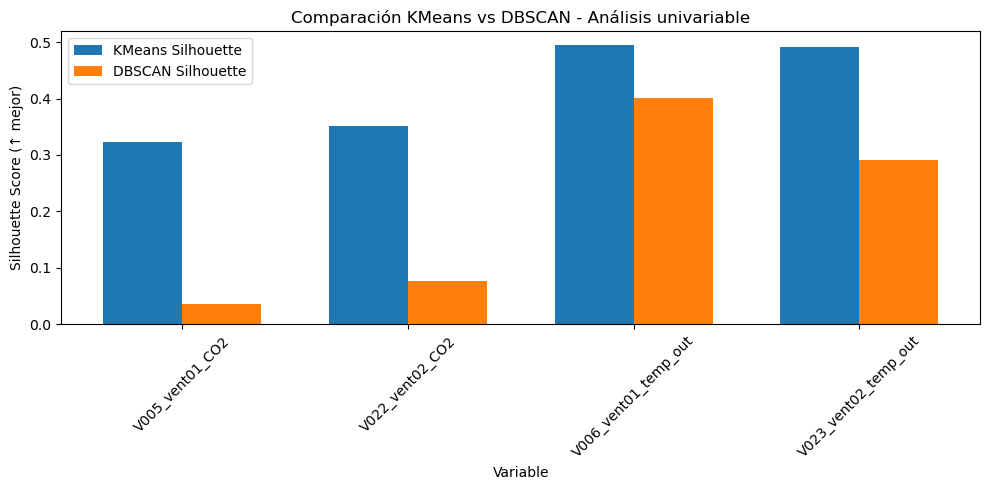


Mejor técnica de clustering por variable (B - univariable):
V005_vent01_CO2: KMeans
V022_vent02_CO2: KMeans
V006_vent01_temp_out: KMeans
V023_vent02_temp_out: KMeans


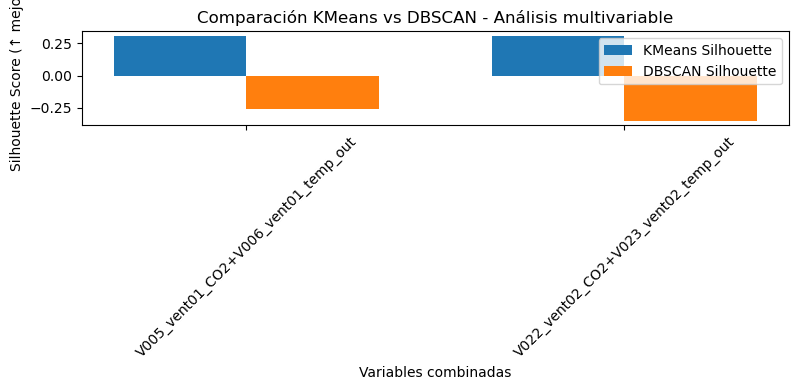


Mejor técnica de clustering por combinación (D - multivariable):
V005_vent01_CO2+V006_vent01_temp_out: KMeans
V022_vent02_CO2+V023_vent02_temp_out: KMeans


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import numpy as np

# --------------------------
# Cargar y preparar datos
# --------------------------
df = pd.read_csv(r'\Users\Soporte-NuCom\Desktop\DOCUMENTOS VARIOS\DRAGON\MATERIAS\INTELIGENCIA ARTIFICIAL\Talleres\Taller3\P1_UML\data\data.csv', sep=";")
df["timestamp"] = pd.to_datetime(df["timestamp"], format="%d.%m.%Y %H:%M")
df.set_index("timestamp", inplace=True)

# Agrupar por día y convertir en vectores
daily_profiles = df.groupby(df.index.date).agg({
    'V005_vent01_CO2': list,
    'V022_vent02_CO2': list,
    'V006_vent01_temp_out': list,
    'V023_vent02_temp_out': list
})

# Funciones auxiliares
def build_feature_matrix(column_name):
    return daily_profiles[column_name].apply(lambda x: pd.Series(x)).dropna().values.tolist()

def build_feature_matrix_multivariable(columns):
    return daily_profiles.apply(lambda row: row[columns[0]] + row[columns[1]], axis=1).dropna().apply(pd.Series).dropna().values.tolist()

def plot_cluster_labels(labels, title):
    plt.figure(figsize=(12, 3))
    plt.plot(labels, marker='o', linestyle='-', alpha=0.7)
    plt.title(title)
    plt.xlabel("Días")
    plt.ylabel("Etiqueta de cluster")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_anomalies(anomalies, title):
    plt.figure(figsize=(12, 3))
    plt.plot(anomalies, marker='o', linestyle='-', alpha=0.7)
    plt.title(title)
    plt.xlabel("Días")
    plt.ylabel("Anomalía (-1: anómalo, 1: normal)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# --------------------------
# Literal B: Patrones univariable
# --------------------------
scaler = StandardScaler()
univariable_results = {}

for var in ['V005_vent01_CO2', 'V022_vent02_CO2', 'V006_vent01_temp_out', 'V023_vent02_temp_out']:
    data_matrix = build_feature_matrix(var)
    data_scaled = scaler.fit_transform(data_matrix)

    kmeans = KMeans(n_clusters=3, random_state=0).fit(data_scaled)
    dbscan = DBSCAN(eps=1.5, min_samples=3).fit(data_scaled)

    sil_kmeans = silhouette_score(data_scaled, kmeans.labels_)
    sil_dbscan = silhouette_score(data_scaled, dbscan.labels_) if len(set(dbscan.labels_)) > 1 else -1

    better = 'KMeans' if sil_kmeans > sil_dbscan else 'DBSCAN'

    univariable_results[var] = {
        'kmeans': kmeans.labels_,
        'dbscan': dbscan.labels_,
        'silhouette_kmeans': sil_kmeans,
        'silhouette_dbscan': sil_dbscan,
        'better_cluster': better
    }

    plot_cluster_labels(kmeans.labels_, f"KMeans - {var}")
    plot_cluster_labels(dbscan.labels_, f"DBSCAN - {var}")

# --------------------------
# Literal C: Anomalías univariable
# --------------------------
anomaly_results_uni = {}
anomaly_scores = {}

for var in ['V005_vent01_CO2', 'V022_vent02_CO2', 'V006_vent01_temp_out', 'V023_vent02_temp_out']:
    data_matrix = build_feature_matrix(var)
    data_scaled = scaler.fit_transform(data_matrix)

    iso = IsolationForest(contamination=0.1, random_state=42)
    anomalies = iso.fit_predict(data_scaled)
    scores = iso.decision_function(data_scaled)

    anomaly_results_uni[var] = anomalies
    anomaly_scores[var] = scores.mean()

    plot_anomalies(anomalies, f"Anomalías - {var}")

# --------------------------
# Literal D: Patrones multivariable
# --------------------------
multivariable_results = {}

for pair in [('V005_vent01_CO2', 'V006_vent01_temp_out'), ('V022_vent02_CO2', 'V023_vent02_temp_out')]:
    data_matrix = build_feature_matrix_multivariable(pair)
    data_scaled = scaler.fit_transform(data_matrix)

    kmeans = KMeans(n_clusters=3, random_state=0).fit(data_scaled)
    dbscan = DBSCAN(eps=1.5, min_samples=3).fit(data_scaled)

    sil_kmeans = silhouette_score(data_scaled, kmeans.labels_)
    sil_dbscan = silhouette_score(data_scaled, dbscan.labels_) if len(set(dbscan.labels_)) > 1 else -1

    better = 'KMeans' if sil_kmeans > sil_dbscan else 'DBSCAN'

    multivariable_results[f'{pair[0]}+{pair[1]}'] = {
        'silhouette_kmeans': sil_kmeans,
        'silhouette_dbscan': sil_dbscan,
        'better_cluster': better
    }

    plot_cluster_labels(kmeans.labels_, f"KMeans - {pair[0]} + {pair[1]}")
    plot_cluster_labels(dbscan.labels_, f"DBSCAN - {pair[0]} + {pair[1]}")

# --------------------------
# Comparación de técnicas
# --------------------------
labels = list(univariable_results.keys())
sil_kmeans = [univariable_results[k]['silhouette_kmeans'] for k in labels]
sil_dbscan = [univariable_results[k]['silhouette_dbscan'] for k in labels]
better_cluster = [univariable_results[k]['better_cluster'] for k in labels]

fig, ax = plt.subplots(figsize=(10, 5))
bar_width = 0.35
index = np.arange(len(labels))

plt.bar(index, sil_kmeans, bar_width, label='KMeans Silhouette')
plt.bar(index + bar_width, sil_dbscan, bar_width, label='DBSCAN Silhouette')

plt.xlabel('Variable')
plt.ylabel('Silhouette Score (↑ mejor)')
plt.title('Comparación KMeans vs DBSCAN - Análisis univariable')
plt.xticks(index + bar_width / 2, labels, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

print("\nMejor técnica de clustering por variable (B - univariable):")
for var in labels:
    print(f"{var}: {univariable_results[var]['better_cluster']}")

# Multivariable
multi_labels = list(multivariable_results.keys())
multi_sil_kmeans = [multivariable_results[k]['silhouette_kmeans'] for k in multi_labels]
multi_sil_dbscan = [multivariable_results[k]['silhouette_dbscan'] for k in multi_labels]
multi_better_cluster = [multivariable_results[k]['better_cluster'] for k in multi_labels]

fig, ax = plt.subplots(figsize=(8, 4))
bar_width = 0.35
index = np.arange(len(multi_labels))

plt.bar(index, multi_sil_kmeans, bar_width, label='KMeans Silhouette')
plt.bar(index + bar_width, multi_sil_dbscan, bar_width, label='DBSCAN Silhouette')

plt.xlabel('Variables combinadas')
plt.ylabel('Silhouette Score (↑ mejor)')
plt.title('Comparación KMeans vs DBSCAN - Análisis multivariable')
plt.xticks(index + bar_width / 2, multi_labels, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

print("\nMejor técnica de clustering por combinación (D - multivariable):")
for var in multi_labels:
    print(f"{var}: {multivariable_results[var]['better_cluster']}")



Resumen de centroides por clúster (V005_vent01_CO2 + V006_vent01_temp_out):
            h00   h01   h02   h03   h04   h05   h06   h07   h08   h09  ...  \
Cluster 0  0.66  0.63  0.61  0.58  0.55  0.54  0.37  0.37  0.63  0.75  ...   
Cluster 1 -0.39 -0.38 -0.36 -0.33 -0.31 -0.30 -0.19 -0.15 -0.16 -0.17  ...   
Cluster 2 -0.26 -0.26 -0.26 -0.28 -0.30 -0.30 -0.26 -0.42 -1.03 -1.29  ...   

            h38   h39   h40   h41   h42   h43   h44   h45   h46   h47  
Cluster 0  0.10  0.09  0.09  0.09 -0.11 -0.45 -0.71 -0.82 -0.83 -0.83  
Cluster 1  0.49  0.50  0.50  0.50  0.52  0.60  0.64  0.65  0.69  0.76  
Cluster 2 -1.98 -1.98 -1.98 -1.98 -1.58 -0.99 -0.47 -0.24 -0.36 -0.59  

[3 rows x 48 columns]


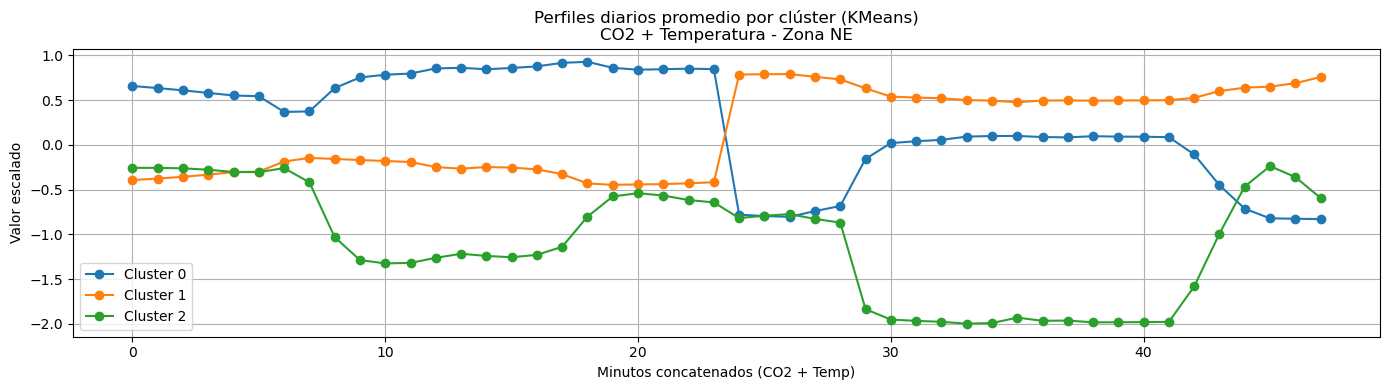

In [2]:
# --------------------------
# Centroides de clústeres (literal D multivariable con KMeans)
# --------------------------
print("\nResumen de centroides por clúster (V005_vent01_CO2 + V006_vent01_temp_out):")
pair = ('V005_vent01_CO2', 'V006_vent01_temp_out')
data_matrix = build_feature_matrix_multivariable(pair)
data_scaled = scaler.fit_transform(data_matrix)
kmeans = KMeans(n_clusters=3, random_state=0).fit(data_scaled)

centroids = kmeans.cluster_centers_
centroid_df = pd.DataFrame(centroids)
centroid_df.columns = [f"h{str(i).zfill(2)}" for i in range(len(centroid_df.columns))]  # hora:00, hora:01...
centroid_df.index = [f"Cluster {i}" for i in range(centroid_df.shape[0])]
print(centroid_df.round(2))

# Gráfico comparativo de centroides por hora
plt.figure(figsize=(14, 4))
for i, row in centroid_df.iterrows():
    plt.plot(row.values, marker='o', label=i)
plt.title("Perfiles diarios promedio por clúster (KMeans)\nCO2 + Temperatura - Zona NE")
plt.xlabel("Minutos concatenados (CO2 + Temp)")
plt.ylabel("Valor escalado")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



Perfiles promedio por clúster (DBSCAN) - V005_vent01_CO2 + V006_vent01_temp_out
          h00   h01   h02   h03   h04   h05   h06   h07   h08   h09  ...  \
cluster                                                              ...   
0       -1.72 -1.75 -1.79 -1.83 -1.88 -1.92 -1.88 -1.93 -2.12 -1.96  ...   
1       -1.24 -1.15 -1.12 -1.14 -1.18 -1.21 -0.94 -0.65 -0.30  0.01  ...   
2       -2.16 -2.24 -2.28 -2.30 -2.13 -1.84 -1.49 -1.29 -0.78 -0.32  ...   
3       -0.28 -0.26 -0.23 -0.20 -0.19 -0.24 -0.20 -0.33 -0.93 -1.19  ...   
4       -0.61 -0.62 -0.62 -0.62 -0.63 -0.61 -0.53 -0.65 -1.19 -1.38  ...   
5       -0.66 -0.66 -0.67 -0.69 -0.70 -0.96 -0.78 -0.40  0.25  0.67  ...   
6       -1.25 -1.28 -1.30 -1.36 -1.43 -1.47 -1.46 -1.57 -1.88 -1.82  ...   
7       -0.02  0.01  0.04  0.06  0.07 -0.03 -0.05 -0.00  0.25  0.33  ...   
8        0.86  0.89  0.93  0.94  0.95  0.66  0.53  0.56  0.72  0.69  ...   
9        0.35  0.36  0.32  0.22  0.16  0.22 -0.36 -0.49 -0.00  0.77  ...   
10     

C:\Users\Soporte-NuCom\AppData\Local\Temp\ipykernel_22768\1196055475.py:31: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


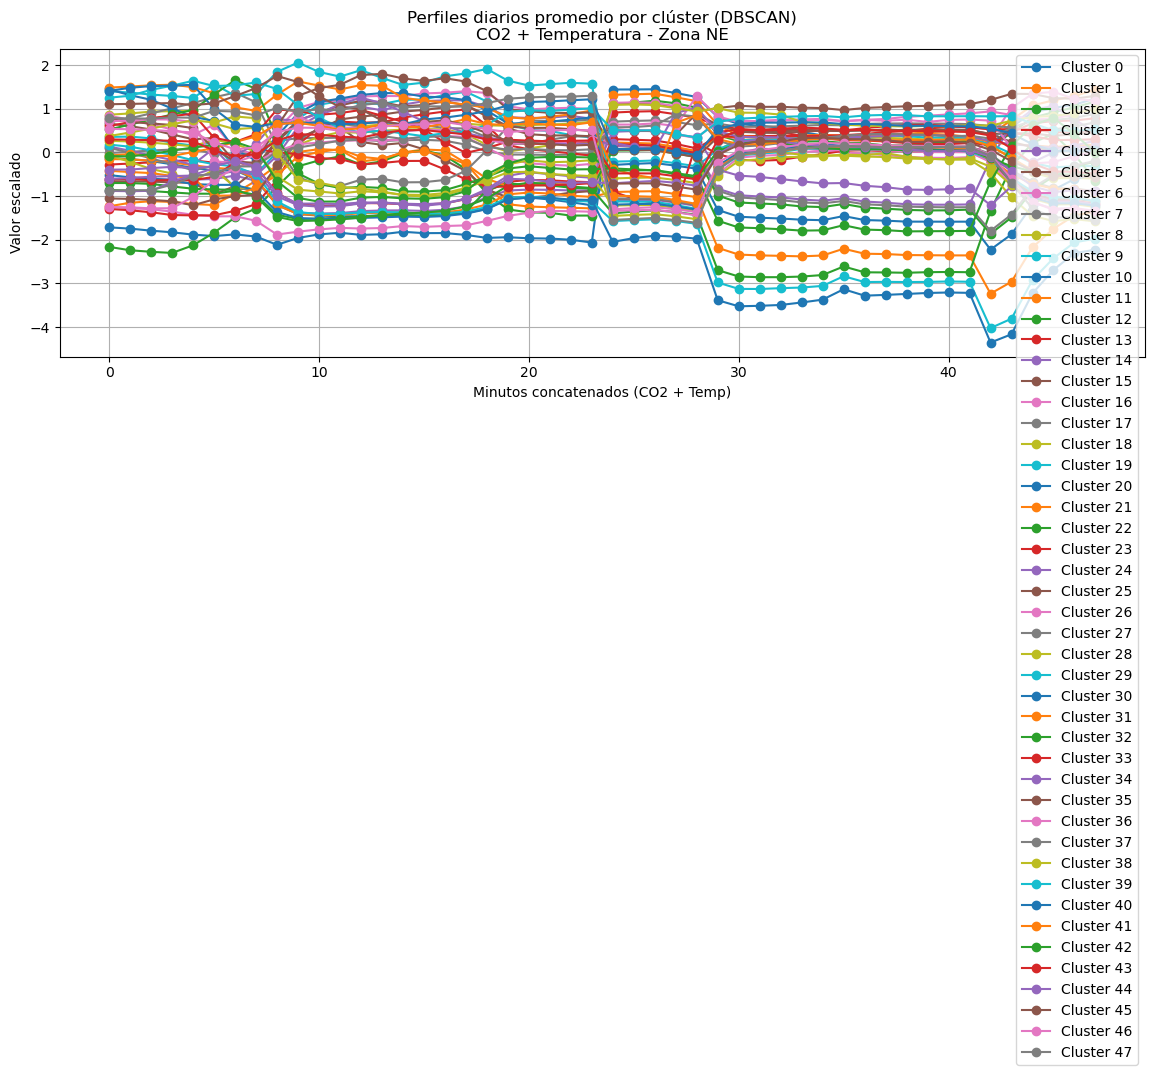

In [4]:
# --------------------------
# Perfil promedio por clúster con DBSCAN (Zona NE)
# --------------------------
print("\nPerfiles promedio por clúster (DBSCAN) - V005_vent01_CO2 + V006_vent01_temp_out")
dbscan = DBSCAN(eps=1.5, min_samples=3)
db_labels = dbscan.fit_predict(data_scaled)

# Crear DataFrame con etiquetas
df_dbscan = pd.DataFrame(data_scaled)
df_dbscan['cluster'] = db_labels

# Excluir ruido (-1)
filtered_df = df_dbscan[df_dbscan['cluster'] != -1]
mean_profiles = filtered_df.groupby('cluster').mean()

# Renombrar columnas
mean_profiles.columns = [f"h{str(i).zfill(2)}" for i in range(mean_profiles.shape[1])]

# Mostrar tabla de perfiles promedio
print(mean_profiles.round(2))

# Graficar los perfiles promedio
plt.figure(figsize=(14, 4))
for i, row in mean_profiles.iterrows():
    plt.plot(row.values, marker='o', label=f"Cluster {i}")
plt.title("Perfiles diarios promedio por clúster (DBSCAN)\nCO2 + Temperatura - Zona NE")
plt.xlabel("Minutos concatenados (CO2 + Temp)")
plt.ylabel("Valor escalado")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Detección de anomalías multivariable - CO2 + Temperatura NE
Total de días detectados como anómalos: 108 de 1078


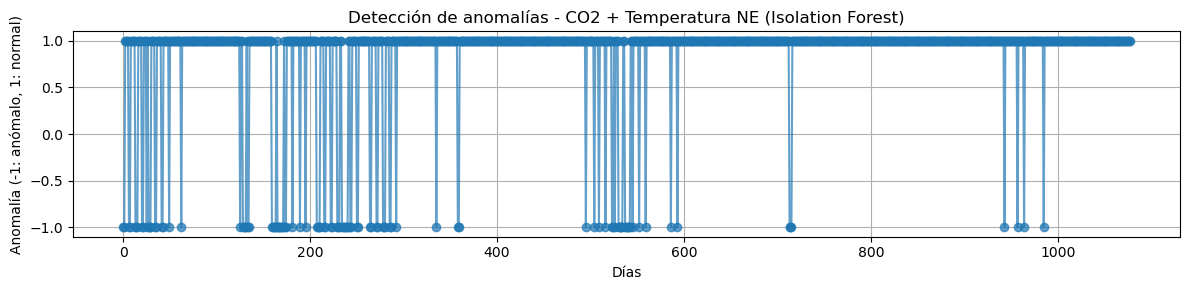

In [5]:
# --------------------------
# Anomalías multivariable (Isolation Forest) - Zona NE
# --------------------------
print("\nDetección de anomalías multivariable - CO2 + Temperatura NE")
pair = ('V005_vent01_CO2', 'V006_vent01_temp_out')
data_matrix = build_feature_matrix_multivariable(pair)
data_scaled = scaler.fit_transform(data_matrix)

iso = IsolationForest(contamination=0.1, random_state=42)
anomaly_labels = iso.fit_predict(data_scaled)

# Mostrar resumen de anomalías
num_anomalies = list(anomaly_labels).count(-1)
print(f"Total de días detectados como anómalos: {num_anomalies} de {len(anomaly_labels)}")

# Graficar anomalías
plt.figure(figsize=(12, 3))
plt.plot(anomaly_labels, marker='o', linestyle='-', alpha=0.7)
plt.title("Detección de anomalías - CO2 + Temperatura NE (Isolation Forest)")
plt.xlabel("Días")
plt.ylabel("Anomalía (-1: anómalo, 1: normal)")
plt.grid(True)
plt.tight_layout()
plt.show()